# HR Diagram with Hipparcos Catalog 

In this project, I used Python tools to examine stellar data from the HIPPARCOS Catalog and create a HR diagram from the data. I was inspired to do this project due to my own personal interest in Astrophysics as well as a dated blogpost I found [here](http://balbuceosastropy.blogspot.com/2014/03/construction-of-hertzsprung-russell.html). This post was created nearly a decade ago, and I challenged myself to recreate three of the plots from the blog post with modern Python. Beyond that, I also improved upon cleaning of the data as well as a more in depth data analysis of the Hipparcos Catalog. 

## Introduction 

### What is the Hipparcos Catalog? 

The Hipparcos Catalog is a catalog of stellar information taken and calculated from the Hipparcos satellite. The Hipparcos satellite operated from 1989 to 1993, and was the first astronomical satellite dedicated to taking positional measurements in space. This type of astronomy is often referred to as astrometry. The satellite measured astronomical data for over 118,000 stars [1](https://www.cosmos.esa.int/web/hipparcos/catalogues). Because of its age, the Hipparcos Catalog is well studied, and modern day interfaces make it easy to extract data from the catalog [here](http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=I/239/hip_main). The database contains over 30 different astronimical data points per object, but in this project I will only be using a few. 

### What is an HR Diagram? 

HR diagrams are astronomical diagrams used to illustrate how different star types relate to their magnitude (a type of brightness) and temperature. Since many stellar characteristics can be linked to their temperature, it is appropriate to use other caracteristics such as spectral type and color index to recreate HR diagrams. 

<img src="http://cdn.eso.org/images/screen/eso0728c.jpg" width=500>
<center>HR diagram from ESO.org</center>


# Data Import and Cleaning 

For organizational purposes, all the Python packages I used are below. 

In [1]:
import pandas as pd 
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

I read the file containing the Hipparcos data into a Pandas dataframe. 

In [2]:
#import tsv file 
df = pd.read_csv('asu.tsv', skiprows=42, sep=';', header=None,
                   names = ['HIP', # id
                            'Vmag', # V-band apparent magnitude 
                            'Plx', # parallax
                            'B-V', #B-V color index
                            'SpType']) #spectral type

df.head()

,HIP,Vmag,Plx,B-V,SpType
0,1,9.10,3.54,0.482,F5
1,2,9.27,21.90,0.999,K3V
2,3,6.61,2.81,-0.019,B9
3,4,8.06,7.75,0.370,F0V
4,5,8.55,2.87,0.902,G8III


In [3]:
df.shape

(118218, 5)

The dataset contained data for 118,218 stars. Upon examining the data, I saw that there were many missing values as well as empty cells. I began cleaning the data by removing any cells that only contained spaces, were empty, or contained NaN values. 

In [4]:
#dropping rows with missing values

#the Plx column contains several rows with multiple spaces. These are replaced with NaN
df.replace('       ', np.nan, inplace=True)

##the B-V column contains several rows with multiple spaces. These are replaced with NaN
df.replace('      ',np.nan, inplace=True)

#dropping all NaN rows
df.dropna(inplace=True)

df.head()

,HIP,Vmag,Plx,B-V,SpType
0,1,9.10,3.54,0.482,F5
1,2,9.27,21.90,0.999,K3V
2,3,6.61,2.81,-0.019,B9
3,4,8.06,7.75,0.370,F0V
4,5,8.55,2.87,0.902,G8III


I then began preparing the data for calculations. I changed the numerical data into floating point numbers. I also removed any invalid parallax measurements. Parallax is an angle relating the earth, and sun, and a celestial object, and parallax values equal or lesser than 0 are due to erroneous measurements (they are impossible in real life!). 

<img src="https://www.esa.int/var/esa/storage/images/esa_multimedia/images/2013/06/measuring_stellar_distances_by_parallax/12886273-3-eng-GB/Measuring_stellar_distances_by_parallax_pillars.jpg" width=500>
<center>A diagram depicting parallex from the European Space Agency</center>

In [5]:
#converting string types in df to floats for calculations 
df['Vmag'] = df['Vmag'].astype(float)
df['Plx'] = df['Plx'].astype(float)
df['B-V'] = df['B-V'].astype(float)

#negative parallax values are caused by erroneous measurements. 
#Log10 cannot take negative numbers or 0, so these should be removed. 
error_drop = df[ df['Plx'] <=0 ].index
df.drop(error_drop , inplace=True)

df.head()

,HIP,Vmag,Plx,B-V,SpType
0,1,9.10,3.54,0.482,F5
1,2,9.27,21.90,0.999,K3V
2,3,6.61,2.81,-0.019,B9
3,4,8.06,7.75,0.370,F0V
4,5,8.55,2.87,0.902,G8III


I them began transforming the SpType column for calculations. Spectral types consist of a letter (usually O,B,A,F,G,K and M) and a number, and can be analogous with the temperature of a star. However, creating a plot based on letter order is difficuly, so I converted each letter to a number. 

I first made a copy of the original Spectral Type values to be used later. I then removed any unuseable data from the table, such as unnecessary numbers and letters, types missing a number or letter, and types with characters not included in my HR diagram (for example, I excluded the Spectral Type C from the dataset due to how uncommon it is). After attaching a numerical value to each spectral type, I converted it to a useable integer.

In [6]:
#creating a copy of the SpTypes without changes to the Spectral Types for later use 
df['Og_SpType'] = df['SpType']

#the first 2 identifiers are the most important information in the Spectral types, so we drop all other letters in the column
df['SpType'] = df['SpType'].str[:2]

#we also remove spectral types that are < 2 characters, we need a type and a number 
mask = (df['SpType'].str.len() > 1)
df = df.loc[mask]

#we remove spectral types where the second character is not useable, ex: b:, h', mm
mask = df['SpType'].str[1].str.isdigit()
df = df.loc[mask]

#we are only looking at the most common spectral types, O, B A, F, G, K, M, so any other spectral types will be removed 
df = df[df['SpType'].map(lambda s: s[0] in 'OBAFGKM')]

#the x axis of the HR-diagram will be the spectral type, so we quantify this by assigning a number to each spectral type
sequence = {'O':'0', 'B':'1', 'A':'2', 'F':'3', 'G':'4', 'K':'5', 'M':'6'}
df['SpType'] = df['SpType'].apply(lambda s: sequence[s[0]]+s[1])

#convert string to float
df['SpType'].apply(lambda s: float(s))


df.head()

,HIP,Vmag,Plx,B-V,SpType,Og_SpType
0,1,9.10,3.54,0.482,35,F5
1,2,9.27,21.90,0.999,53,K3V
2,3,6.61,2.81,-0.019,19,B9
3,4,8.06,7.75,0.370,30,F0V
4,5,8.55,2.87,0.902,48,G8III


In [7]:
df.count()

HIP          107959
Vmag         107959
Plx          107959
B-V          107959
SpType       107959
Og_SpType    107959
dtype: int64

In [8]:
df.shape

(107959, 6)

After cleaning the data, I had 107,957 data points left to work with. 

# Calculations 

One of the calculations needed to place a star on a HR diagram is the absolute magnitude of the star. This can be calculated with the parallax and apparent magnitude of the star, with the equation: 

$$ M = m + 5*\log{\frac{P}{100}}. $$

where $M$ is the absolute magnitude, $m$ is the apparent magnitude, and $P$ is the parallax angle. I created another column in the table with the absolute magnitude of each star. 

In [9]:
#add a new row which calculates the absolute magnitude of each star 
df['M-V'] = df['Vmag'] + 5 * np.log10(df['Plx']/100.)
df.head()

,HIP,Vmag,Plx,B-V,SpType,Og_SpType,M-V
0,1,9.10,3.54,0.482,35,F5,1.845016
1,2,9.27,21.90,0.999,53,K3V,5.972221
2,3,6.61,2.81,-0.019,19,B9,-1.146468
3,4,8.06,7.75,0.370,30,F0V,2.506509
4,5,8.55,2.87,0.902,48,G8III,0.839409


# Analysis

Now that I had cleaned the data and completed any necessary calculations, I was able to begin analyzing the data. 

In [10]:
df.describe()

,HIP,Vmag,Plx,B-V,M-V
count,107959.000000,107959.000000,107959.000000,107959.000000,107959.000000
mean,59133.341611,8.254114,7.372352,0.694872,1.602443
std,34235.814601,1.233244,10.849568,0.475088,2.303447
min,1.000000,-1.440000,0.010000,-0.400000,-13.310000
25%,29377.500000,7.590000,2.730000,0.348000,0.270939
50%,59127.000000,8.370000,4.780000,0.602000,1.512715
75%,88850.000000,9.030000,8.490000,1.064000,3.058407
max,120132.000000,13.110000,772.330000,3.039000,15.449015


From looking at the data's summary, I saw that these was overall a large amount of variance in numerical values, with high standard deviations. This was expected, as star brightness varies widely with star type. For example, a white dwarf is going to be much dimmer than a red supergiant. Parallax was also expected to have high variance, as astronomers have no control over stellar positons in the sky. 

My first plot showed a HR diagram using Spectral Type vs. Absolute Magnitude (not that the lower a magnitude, the brighter the star. This is why the y axis is reversed). The star ranges from hottest stars (blue) to coolest (red). HR diagrams tend to form a slight 'v' shape in the center, and while that is seen, there also seems to be a lot of smearing of the data. This smearing can be attributed to the small range of integers used in the data (recall, spectral types were quantified into two digit numbers), as there are many stars occupying the same spectral letter and number. 

(15, -15)

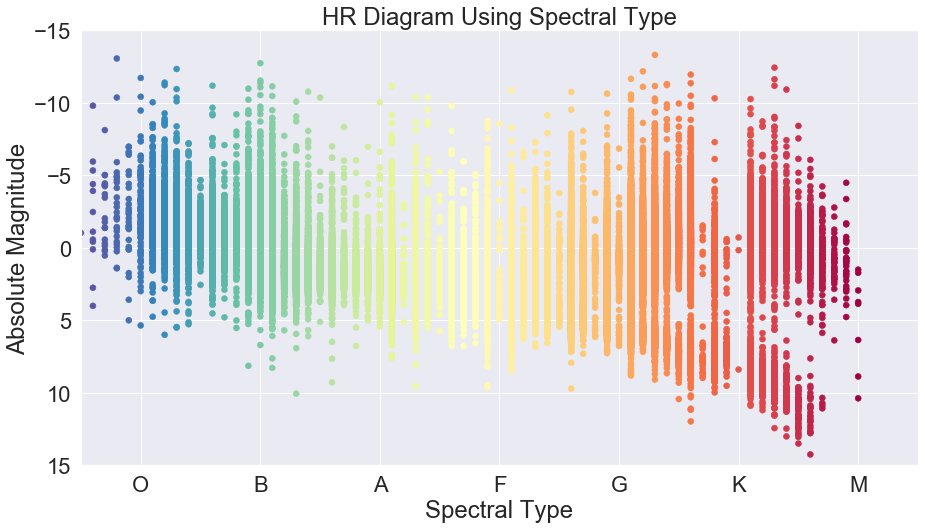

In [11]:
df = df.sort_values(by=['SpType'])

sns.set(rc = {'figure.figsize':(15,8)}, font_scale = 2, style='darkgrid')

plot = sns.scatterplot(x=df['SpType'],
                       y=df['M-V'],
                       edgecolor=None,
                       hue = df['SpType'].astype(int),
                       palette = 'Spectral_r',
                       legend=False)

plot.set_xticks(range(5,75,10))
plot.set_xticklabels(['O', 'B', 'A', 'F', 'G', 'K', 'M'])

plt.xlabel('Spectral Type')
plt.ylabel("Absolute Magnitude")
plt.title('HR Diagram Using Spectral Type')

plot.set_xlim(0, 70)
plot.set_ylim(15, -15)

In order to get a clearer image of the HR diagram, I used the calculated absolute magnitude instead of specttal type. Because this number was more specific, with several decimal figures, I found that this yielded a more spread out and accurrate diaplay of the HR diagram. The HR diagram displays all characteristics of a correctly made HR diagram, such as a slight 'v' shape at the top with a tail trailing behind. For an example of what a HR diagram should look like, here is the HR diagram of data taken from GAIA: 

<img src="https://cdn.sci.esa.int/documents/33580/35361/1567214809100-ESA_Gaia_DR2_HRD_Gaia_625.jpg" width=500>
<center>A diagram depicting the GAIA HR diagram from the  European Space Agency</center>



(15, -15)

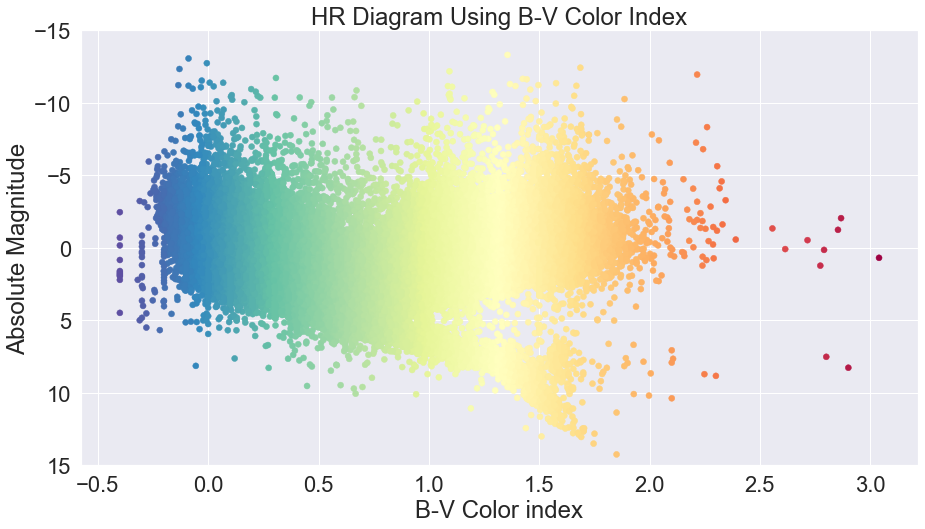

In [12]:
sns.set(rc = {'figure.figsize':(15,8)}, font_scale = 2)

plot = sns.scatterplot(x = df['B-V'],
                       y = df['M-V'],
                       edgecolor=None,
                       hue = df['B-V'], 
                       palette='Spectral_r',
                       legend=False)

plt.xlabel('B-V Color index')
plt.ylabel("Absolute Magnitude")
plt.title('HR Diagram Using B-V Color Index')

plot.set_ylim(15, -15)

Comparing this diagram to the first HR diagram, you could guess that this HR diagram contains mostly main sequence and giant stars. This is correct, and can be confirmed by the dataset. In some of the stars from the Hipparcos catalog, researchers were able to categorize the stars. This categorization was stored in the stars' spectral types: I for supergiants, II for bright giants, III for giants, IV for subgiants, V for main sevience stars and VI and VII for white dwarfs.

In order to access this information, I created a function that would look at each star's spectral type and determine what category the star was in. If no category was given, the category was given a NaN value in the table. I then removed any stars in the dataset that did not have a designated type. 

In [13]:
#Cannot use a dictionary for this, since we are searching inside each individual word 

def star_classifier(SpType):
    if ('VII' in SpType): 
        return 'White Dwarf'
    elif ('VI' in SpType):
        return 'Subdwarf'
    elif ('IV' in SpType): 
        return 'Subgiant'
    elif ('V' in SpType): 
        return 'Main Sequence'
    elif ('III' in SpType):
        return 'Giant'
    elif ("II" in SpType):
        return 'Bright Giant'
    elif ('I' in SpType):
        return 'Supergiant'
    else:
        return np.nan
    

In [14]:
#add another column in the data frame designating star type. drop any stars without a star type 
typelist = []
for star in df['Og_SpType']: 
    typelist.append(star_classifier(star))
    
df['StarType'] = typelist
df.dropna(inplace=True)
df.head()

,HIP,Vmag,Plx,B-V,SpType,Og_SpType,M-V,StarType
39398,39429,2.21,2.33,-0.269,05,O5IAf,-5.953220,Supergiant
10015,10024,9.00,1.68,0.159,06,O6.5V,0.126546,Main Sequence
74877,74941,5.43,0.02,-0.089,07,O7Iab:,-13.064850,Supergiant
26253,26272,7.56,0.28,0.133,07,O7.5III,-5.204210,Giant
98886,98976,7.78,0.67,0.138,07,O7III...,-3.089626,Giant


In [15]:
df.shape

(54340, 8)

After removing any stars that were not given a star type, I had 54,340 stars left in the dataframe. The HR disgram of these stars is below. 

(15, -15)

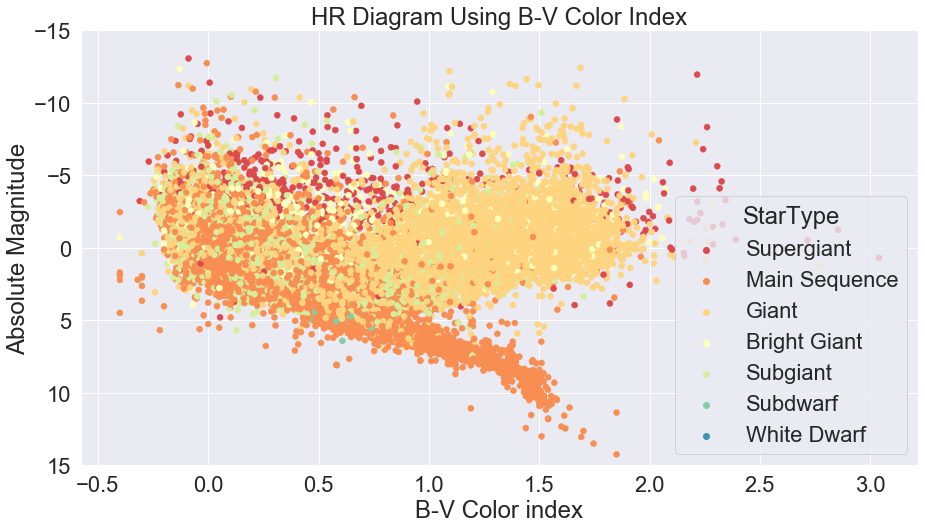

In [16]:
#plot star classification
sns.set(rc = {'figure.figsize':(15,8)}, font_scale = 2, style='darkgrid')

plot = sns.scatterplot(x = df['B-V'],
                       y = df['M-V'],
                       edgecolor=None,
                       #alpha = 0.95,
                       hue = df['StarType'], 
                       palette='Spectral')

plt.xlabel('B-V Color index')
plt.ylabel("Absolute Magnitude")
plt.title('HR Diagram Using B-V Color Index')

plot.set_ylim(15, -15)

As predicted, the majority of the stars were main sequence and giant stars. Now that I had the stars categorized, I was able to look more in depth at the stellar statistics. 

When looking at data in the table, the most relevant categories are absolute magnitude and B-V color index. The rest are determined by cosmological positioning and can't always determine direct properties of a star. Absolute magnitude is a measure of brightness. It's a measure of how bright stars would be if they were all at the same distance from earth. The lower the magnitude, the brighter a star is. B-V index is a measure of blue and visible light, and corresponds to temperature. A lower B-V index indiciates a hotter star while a high B-V index indicated a cooler star. 

In [22]:
df.groupby("StarType")['M-V'].describe().reset_index()

,StarType,count,mean,std,min,25%,50%,75%,max
0,Bright Giant,1117.0,-1.031989,2.197633,-12.340000,-2.317575,-0.845735,0.585603,3.933225
1,Giant,20296.0,0.211444,1.649195,-12.430000,-0.570484,0.421791,1.156843,8.300337
2,Main Sequence,24366.0,2.630459,2.185317,-12.740000,1.306394,2.867398,3.946509,15.449015
3,Subdwarf,16.0,4.647511,0.729147,3.340453,4.374853,4.620453,4.949973,6.416294
4,Subgiant,7798.0,1.413805,1.913780,-11.720000,0.408485,1.601690,2.607104,7.436013
5,Supergiant,746.0,-2.777208,2.531875,-13.064850,-4.374814,-2.664838,-1.249885,4.794565
6,White Dwarf,1.0,-4.702868,NaN,-4.702868,-4.702868,-4.702868,-4.702868,-4.702868


Analyzing the data, we can immediately see that there are not enough white dwarf or subdwarf stars in the dataset to make any conclusions about these star categories. So, they will not be considered in any analysis.

Standard Deviations of M-V Absolute Magnitudes. Note while there is an overall trend, there is still a high degree of variability in the data.


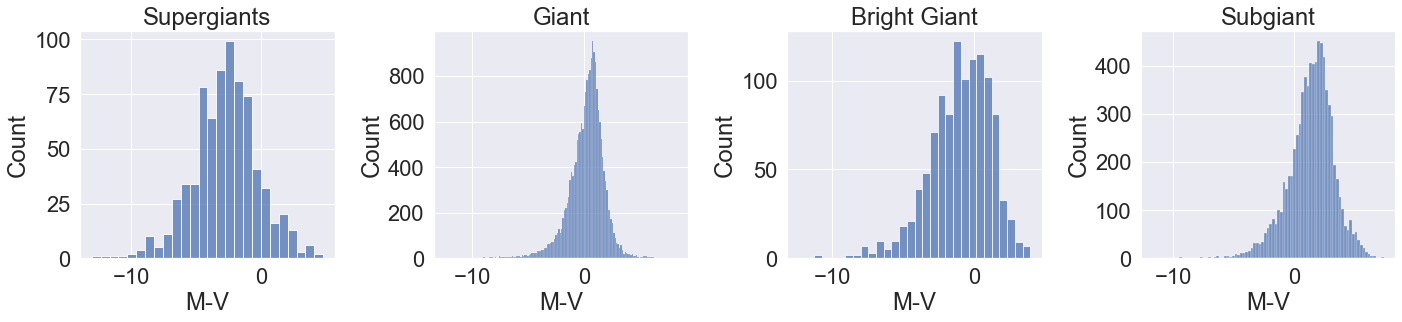

In [75]:
print("Standard Deviations of M-V Absolute Magnitudes. Note while there is an overall trend, there is still a high degree of variability in the data.")

fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(20,5))

sns.histplot(df[df['StarType'] == 'Supergiant']['M-V'], ax=ax1)
ax1.set_title('Supergiants')
#ax1.set_xlabel('US & Non-US Movies')

sns.histplot(df[df['StarType'] == 'Giant']['M-V'], ax=ax2)
ax2.set_title('Giant')

sns.histplot(df[df['StarType'] == 'Bright Giant']['M-V'], ax=ax3)
ax3.set_title('Bright Giant')

sns.histplot(df[df['StarType'] == 'Subgiant']['M-V'], ax=ax4)
ax4.set_title('Subgiant')

sns.histplot(df[df['StarType'] == 'Main Sequence']['M-V'], ax=ax5)
ax5.set_title('Main Sequence')

fig.tight_layout()

Excluding those two categories, the brightest stars on the HR diagram appear to be supergiant stars. The dimmest stars appear to be main sequence stars. This confirms what appeared in the HR diagram. Note that there is a very high standard deviation in these calculations, and this analysis could be greatly improved with a larger sample size. 

In [23]:
df.groupby("StarType")['B-V'].describe().reset_index()

,StarType,count,mean,std,min,25%,50%,75%,max
0,Bright Giant,1117.0,0.702586,0.565542,-0.400,0.175,0.7000,1.12300,2.305
1,Giant,20296.0,1.090154,0.422428,-0.300,0.980,1.1220,1.36500,2.773
2,Main Sequence,24366.0,0.439477,0.317648,-0.400,0.175,0.4830,0.61100,2.042
3,Subdwarf,16.0,0.583438,0.108539,0.469,0.503,0.5590,0.61075,0.892
4,Subgiant,7798.0,0.495170,0.389827,-0.274,0.189,0.4350,0.84775,1.827
5,Supergiant,746.0,0.778074,0.623368,-0.310,0.287,0.6705,1.15825,3.039
6,White Dwarf,1.0,1.108000,NaN,1.108,1.108,1.1080,1.10800,1.108


According to the data summary, the hottest stars appear to be main sequence stars, while the coolest seem to be giant stars. This also confirms the conclusion made from looking at the HR diagrams. 

# Conclusion 

Overall, the Hipparcos Catalog is a great resource for creating HR diagrams. The data from the catalog produced accurate HR diagrams that could easily be created with a few calculations. However, I do not think this data can be used to empirically derive characteristics of star types. This is due to the high standard deviations associated with the data and the small sample size for some data types. 